In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.manifold import TSNE
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn import metrics

import os
import networkx as nx
import numpy as np
import pandas as pd

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

from gensim.models import Word2Vec

import warnings 
import collections
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('whitegrid')

## 0. Functions

In [3]:
def count_score(labels, clusters):
    adj_score = metrics.adjusted_rand_score(labels,clusters)
    return adj_score

def make_graph(labels, edges):
    G = nx.Graph()
    G.add_nodes_from(labels['node'])

    for i, row in edges.iterrows():
        G.add_edge(row['from'],row['to'], weight=1)
    return G 

def count_embeddings(G,labels,dimensions,walk_length,num_walks,p,q,workers,window,min_count,seed):
    rw = BiasedRandomWalk(StellarGraph.from_networkx(G))
    weighted_walks = rw.run(
        nodes=G.nodes(), # root nodes
        length=walk_length,    # maximum length of a random walk
        n=num_walks,          # number of random walks per root node 
        p=p,         # Defines (unormalised) probability, 1/p, of returning to source node
        q=q,         # Defines (unormalised) probability, 1/q, for moving away from source node
        weighted=False, #for weighted random walks
        seed=seed        # random seed fixed for reproducibility
    )
    print("Number of random walks: {}".format(len(weighted_walks)))
    weighted_walks = [[str(j) for j in i] for i in weighted_walks] # int into str
    
    model = Word2Vec(weighted_walks, 
                     size=dimensions, 
                     window=window, 
                     min_count=min_count, 
                     sg=1, 
                     workers=1, 
                     iter=1)
    model_nodes = list(model.wv.vocab)

    return model,model_nodes

def write_to_file(res,param):
    now = datetime.now()
    current_time = now.strftime('%Y%m%d_one_eighth_'+param)
    filename = '../results/' + current_time + '.csv'
    res.to_csv(filename)

In [4]:
def evaluate(G, labels,
            dimensions=128,
            walk_length=80,
            num_walks=10,
            p=1.0,
            q=1.0,
            workers=4,
            window=10,
            min_count=1,
            seed=42):
    
    model,model_nodes = count_embeddings(G,
                                         labels,dimensions,
                                         walk_length,num_walks,p,q,workers,
                                         window,min_count,
                                         seed)
    # the list of known labels inthe model nodes order
    known_labels = []
    for i in model.wv.index2word:
        known_labels.append(labels.loc[int(i)]['label'])
        
    n_clusters = len(labels_list)

    # clustering
    km = KMeans(n_clusters=n_clusters).fit_predict(model.wv.vectors)
    
    adj_score = count_score(known_labels, km)
    
    return adj_score

## 1. Data read

In [5]:
edges = pd.read_csv('../data/clear_cluster_test/one_eighth.csv', header=None, names=('from','to'))
labels = pd.read_csv('../data/clear_cluster_test/labels.csv', header=None, 
                     names=('node','label'))
labels = labels.sort_values(by='label')

labels_list = list(labels['label'].unique())
n_clusters = len(labels['label'].unique())

G = make_graph(labels, edges)

## 2. Parametres sensitivity

In [6]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'adj_rand'])

for dimensions in [2,4,8,16,32,64,80,90,100,110,128,256]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [1]:
                for q in [1]:
                    for window in [10]:
                        for min_count in [1]:
                            adj_rand = evaluate(G,labels,dimensions,
                                     walk_length,num_walks,p,q,
                                     window,min_count)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'adj_rand':adj_rand},
                                        ignore_index=True)
                            
write_to_file(res,'dimensions')

Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250


In [7]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'adj_rand'])
for dimensions in [128]:
    for walk_length in range(20,120,10):
        for num_walks in [10]:
            for p in [1.0]:
                for q in [1.0]:
                    for window in [10]:
                        for min_count in [1]:
                            adj_rand = evaluate(G,labels,dimensions,
                                     walk_length,num_walks,p,q,
                                     window,min_count)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'adj_rand':adj_rand},
                                        ignore_index=True)
                            
write_to_file(res,'walk_length')

Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250


In [8]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'adj_rand'])
for dimensions in [128]:
    for walk_length in [80]:
        for num_walks in range(6,24,2):
            for p in [1.0]:
                for q in [1.0]:
                    for window in [10]:
                        for min_count in [1]:
                            adj_rand = evaluate(G,labels,dimensions,
                                     walk_length,num_walks,p,q,
                                     window,min_count)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'adj_rand':adj_rand},
                                        ignore_index=True)
                            
write_to_file(res,'num_walks')

Number of random walks: 150
Number of random walks: 200
Number of random walks: 250
Number of random walks: 300
Number of random walks: 350
Number of random walks: 400
Number of random walks: 450
Number of random walks: 500
Number of random walks: 550


In [9]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'adj_rand'])
for dimensions in [128]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [0.25, 0.5, 1., 2., 4]:
                for q in [1.0]:
                    for window in [10]:
                        for min_count in [1]:
                            adj_rand = evaluate(G,labels,dimensions,
                                     walk_length,num_walks,p,q,
                                     window,min_count)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'adj_rand':adj_rand},
                                        ignore_index=True)
                            
write_to_file(res,'p')

Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250


In [10]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'adj_rand'])
for dimensions in [128]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [1.0]:
                for q in [0.25, 0.5, 1., 2., 4]:
                    for window in [10]:
                        for min_count in [1]:
                            adj_rand = evaluate(G,labels,dimensions,
                                     walk_length,num_walks,p,q,
                                     window,min_count)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'adj_rand':adj_rand},
                                        ignore_index=True)
                            
write_to_file(res,'q')

Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250


In [11]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'adj_rand'])
for dimensions in [128]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [1.0]:
                for q in [1.0]:
                    for window in range(2,22,2):
                        for min_count in [1]:
                            adj_rand = evaluate(G,labels,dimensions,
                                     walk_length,num_walks,p,q,
                                     window,min_count)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'adj_rand':adj_rand},
                                        ignore_index=True)
                            
write_to_file(res,'window')

Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250


In [12]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'adj_rand'])
for dimensions in [128]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [1.0]:
                for q in [1.0]:
                    for window in [10]:
                        for min_count in [1,2,3,4,5]:
                            adj_rand = evaluate(G,labels,dimensions,
                                     walk_length,num_walks,p,q,
                                     window,min_count)

                            res = res.append(
                                        {'dimensions':dimensions,
                                        'walk_length':walk_length,'num_walks':num_walks,
                                        'p':p,'q':q,
                                        'window':window,'min_count':min_count,
                                        'adj_rand':adj_rand},
                                        ignore_index=True)
                            
write_to_file(res,'min_count')

Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250


In [13]:
res = pd.DataFrame(columns=['dimensions',
                            'walk_length','num_walks',
                            'p','q',
                            'window','min_count',
                            'seed',
                            'adj_rand'])
for dimensions in [128]:
    for walk_length in [80]:
        for num_walks in [10]:
            for p in [1.0]:
                for q in [1.0]:
                    for window in [10]:
                        for min_count in [1]:
                            for seed in [0,1,3,4,7,11,18,39]:
                                adj_rand = evaluate(G,labels,dimensions,
                                         walk_length,num_walks,p,q,
                                         window,min_count,
                                         seed)

                                res = res.append(
                                            {'dimensions':dimensions,
                                            'walk_length':walk_length,'num_walks':num_walks,
                                            'p':p,'q':q,
                                            'window':window,'min_count':min_count,
                                             'seed':seed,
                                            'adj_rand':adj_rand},
                                            ignore_index=True)
                            
write_to_file(res,'seed')

Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250
Number of random walks: 250


## 3.Visualization of the results

In [14]:
res_dim = pd.read_csv('../results/20200525_one_eighth_dimensions.csv')
res_walk_length = pd.read_csv('../results/20200525_one_eighth_walk_length.csv')
res_num_walks = pd.read_csv('../results/20200525_one_eighth_num_walks.csv')
res_p = pd.read_csv('../results/20200525_one_eighth_p.csv')
res_q = pd.read_csv('../results/20200525_one_eighth_q.csv')
res_window = pd.read_csv('../results/20200525_one_eighth_window.csv')
res_min_count = pd.read_csv('../results/20200525_one_eighth_min_count.csv')
res_seed = pd.read_csv('../results/20200525_one_eighth_seed.csv')

In [15]:
x1 = res_dim['dimensions']
y1 = res_dim['adj_rand'].tolist()

x2 = res_walk_length['walk_length']
y2 = res_walk_length['adj_rand'].tolist()

x3 = res_num_walks['num_walks']
y3 = res_num_walks['adj_rand'].tolist()

x4 = res_p['p']
y4 = res_p['adj_rand'].tolist()

x5 = res_q['q']
y5 = res_q['adj_rand'].tolist()

x6 = res_window['window']
y6 = res_window['adj_rand'].tolist()

x7 = res_min_count['min_count']
y7 = res_min_count['adj_rand'].tolist()

x8 = res_seed['seed']
y8 = res_seed['adj_rand'].tolist()

Text(0.5, 1.0, 'title')

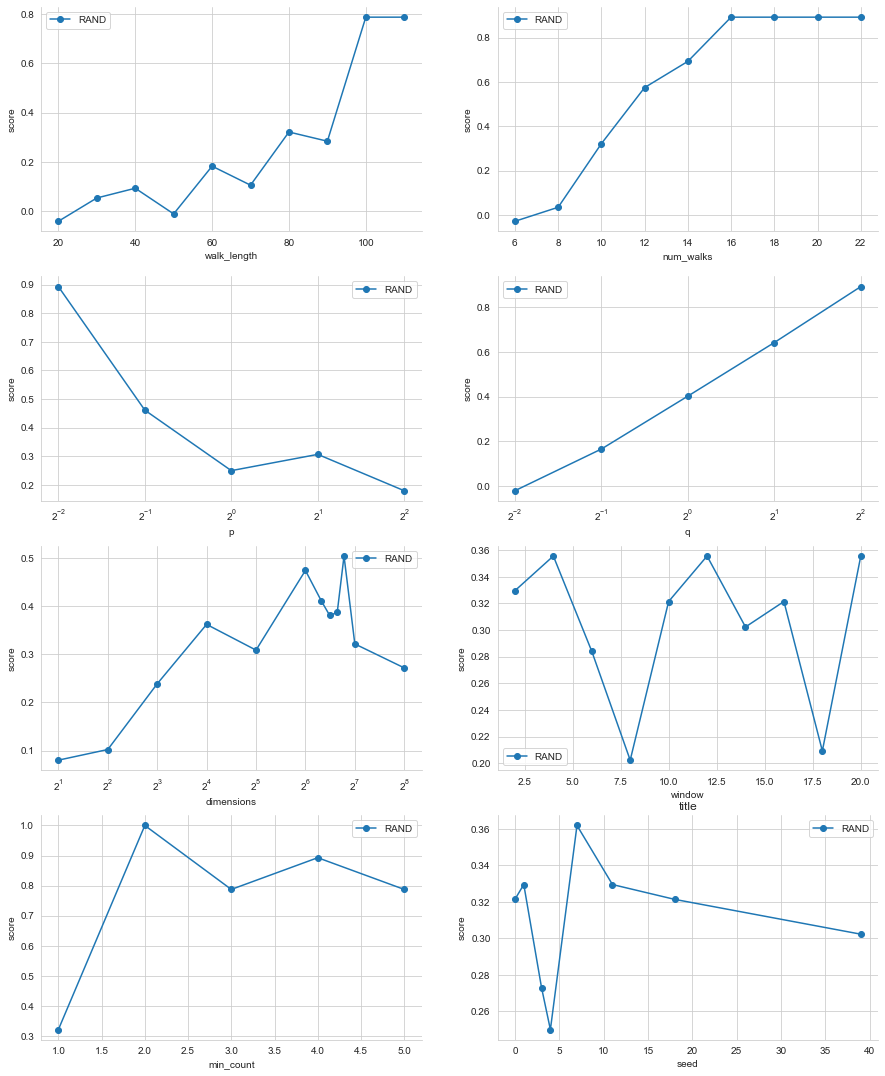

In [22]:
plt.figure(figsize=[15,19])

plt.subplot(421)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x2,y2,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('walk_length')
plt.ylabel('score')

plt.subplot(422)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x3,y3,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('num_walks')
plt.ylabel('score')

plt.subplot(423)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x4,y4,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='best', frameon=True)
plt.xlabel('p')
plt.ylabel('score')

plt.subplot(424)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x5,y5,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='best', frameon=True)
plt.xlabel('q')
plt.ylabel('score')

plt.subplot(425)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x1,y1,'o-',label='RAND')
plt.xscale('log', basex=2)
plt.legend(loc='best', frameon=True)
plt.xlabel('dimensions')
plt.ylabel('score')

plt.subplot(426)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x6,y6,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('window')
plt.ylabel('score')

plt.subplot(427)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x7,y7,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('min_count')
plt.ylabel('score')

plt.subplot(428)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.plot(x8,y8,'o-',label='RAND')
plt.legend(loc='best', frameon=True)
plt.xlabel('seed')
plt.ylabel('score')